In [19]:
from __future__ import division
from math import *
import numpy as np
import sys
import os
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogFormatterSciNotation

import pandas as pd
import numpy as np
import matplotlib, os
import matplotlib.pyplot as plt
# Matplotlib configuration
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.style.use('classic')
plt.rcParams['xtick.direction']     = 'in'
plt.rcParams['ytick.direction']     = 'in'
plt.rcParams['xtick.top']           = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right']         = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.cm as cm

from matplotlib import pyplot
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
pyplot.rcParams.update(params)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import sys
sys.path.append("/Users/oozdal/packages/ma5-histo")
sys.path.append("/Users/oozdal/packages/ma5_expert")

import src.SafReader as sr
from CutFlowReader import Collection 

In [20]:
def df(fileLoc):
    data = sr.read(fileLoc=fileLoc)
    floatCols=['binMin', 'binMax', 'value']
    data[floatCols]  = data[floatCols].apply(pd.to_numeric, errors='coerce')
    data["bin"]      = (data.binMin+data.binMax)/2
    data             = data[data.binMax != np.inf]
    data             = data[data.binMin != -1*np.inf]
    data["binlabel"] = (data.binMin+data.binMax)/2
    return data

In [21]:
lumi=3000.

# Standard Model 

In [22]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SM = Collection(collection_path= AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SMll_Mll4500and8000/SMll_Mll4500and8000.saf',
                    lumi           = 3000.)
SM_sumw   = SM['Rap_No'][0].sumw
SM_histos = df(AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Histograms/histos.saf')

In [23]:
SM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SM.csv', header=0, sep=",")
SM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]
print(min(SM_df['Mll']))

4500.0


Let's apply some bounds

In [24]:
SM_df = SM_df[ (SM_df["Mll"] >= 5000.)  & (SM_df["Mll"] <= 6000.) ]      # Mll [5-6] TeV
SM_df = SM_df[ (SM_df["Eta_lp"] <= 2.5) & (SM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
SM_df = SM_df[ (SM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for the SM

In [25]:
SM_AFB_pos = SM_df[ np.cos(SM_df["angle_CM_true"]) > 0. ]
SM_AFB_neg = SM_df[ np.cos(SM_df["angle_CM_true"]) < 0. ]

BinNumber = 20
BinFirst  = 5000.
BinLast   = 6000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SM_AFB_pos[:][ (SM_AFB_pos["Mll"]>bins[i]) & (SM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SM_AFB_neg[:][ (SM_AFB_neg["Mll"]>bins[i]) & (SM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)
print(AFB_SM)

SM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)
#Number of Events
NumofEvents_LepPos_SM = TotEvWeight_LepPos_Arr2*lumi*SM.xsec*1000/SM_sumw
NumofEvents_LepNeg_SM = TotEvWeight_LepNeg_Arr2*lumi*SM.xsec*1000/SM_sumw

[0.59847994 0.60015768 0.59680567 0.59806896 0.59522245 0.59955078
 0.59665955 0.59988278 0.59433124 0.598967   0.60083503 0.60121677
 0.60174365 0.59897246 0.59562304 0.60050983 0.60100638 0.59316952
 0.60336167 0.6028439 ]


# UMSSM Psi Model

In [26]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

UMSSM_Psi = Collection(collection_path= AFB_data+'/usm/14TeV/_usm_psi/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/usm/14TeV/_usm_psi/_usm_psi.saf',
                    lumi           = 3000.)
UMSSM_Psi_sumw   = UMSSM_Psi['Rap_00'][0].sumw

In [27]:
UMSSM_Psi_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/usm_psi.csv', header=0, sep=",")
UMSSM_Psi_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

In [28]:
print(max(UMSSM_Psi_df["Mll"]))

6000.0


Let's apply some bounds

In [29]:
UMSSM_Psi_df = UMSSM_Psi_df[ (UMSSM_Psi_df["Mll"] >= 5000.)  & (UMSSM_Psi_df["Mll"] <= 6000.) ]      # Mll [5-6] TeV
UMSSM_Psi_df = UMSSM_Psi_df[ (UMSSM_Psi_df["Eta_lp"] <= 2.5) & (UMSSM_Psi_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
UMSSM_Psi_df = UMSSM_Psi_df[ (UMSSM_Psi_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for UMSSM Psi Model

In [30]:
UMSSM_Psi_AFB_pos = UMSSM_Psi_df[ np.cos(UMSSM_Psi_df["angle_CM_true"]) > 0. ]
UMSSM_Psi_AFB_neg = UMSSM_Psi_df[ np.cos(UMSSM_Psi_df["angle_CM_true"]) < 0. ]

BinNumber = 20
BinFirst  = 5000.
BinLast   = 6000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = UMSSM_Psi_AFB_pos[:][ (UMSSM_Psi_AFB_pos["Mll"]>bins[i]) & (UMSSM_Psi_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = UMSSM_Psi_AFB_neg[:][ (UMSSM_Psi_AFB_neg["Mll"]>bins[i]) & (UMSSM_Psi_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_UMSSM_Psi     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

UMSSM_Psi_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)
#Number of Events
NumofEvents_LepPos_Psi = TotEvWeight_LepPos_Arr2*lumi*UMSSM_Psi.xsec*1000/UMSSM_Psi_totsumw
NumofEvents_LepNeg_Psi = TotEvWeight_LepNeg_Arr2*lumi*UMSSM_Psi.xsec*1000/UMSSM_Psi_totsumw

# AFB Plotting for E6 - Psi Model

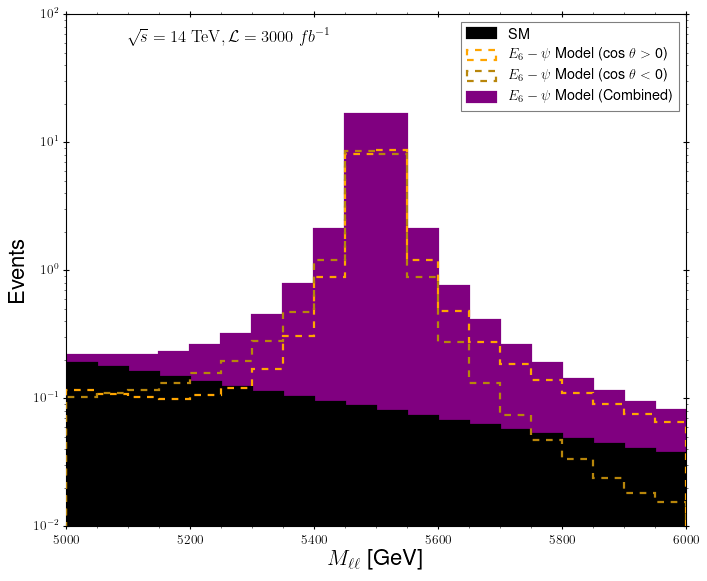

In [34]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 20
BinFirst  = 5000.
BinLast   = 6000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \psi$ Model", fontsize=20)
plt.hist(binlabel,bins=bins,
             label=r'SM', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)
plt.hist(binlabel,bins=bins,
             label=r'$E_6 - \psi$ Model (cos $\theta > $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepPos_Psi, facecolor="orange",
             color=None, edgecolor='orange', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=7)
plt.hist(binlabel,bins=bins,
             label=r'$E_6 - \psi$ Model (cos $\theta < $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepNeg_Psi, facecolor="darkgoldenrod",
             color=None, edgecolor='darkgoldenrod', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=8)
plt.hist(binlabel,bins=bins,
             label=r'$E_6 - \psi$ Model (Combined)', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_Psi+NumofEvents_LepNeg_Psi, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)
plt.xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
plt.ylabel('Events' , fontsize=20)
#plt.xscale('log')
plt.yscale('log')

ax1.text(5100, 60, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)


leg = ax1.legend(loc='upper right',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
#ax1.set_ylim([0.,0.8])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/Mll_E6PsiModel.png') 
plt.show()

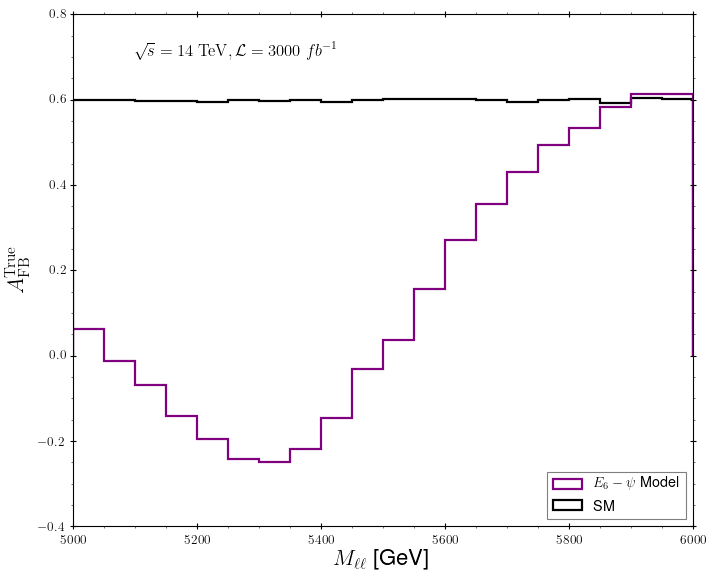

In [33]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 20
BinFirst  = 5000.
BinLast   = 6000.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \psi$ Model", fontsize=20)
plt.hist(binlabel,bins=bins,
             label=r"$E_6 - \psi$ Model", histtype="step", rwidth=1.0,
             weights=AFB_UMSSM_Psi, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)
plt.hist(binlabel,bins=bins,
             label=r"SM", histtype="step", rwidth=1.0,
             weights=AFB_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)
plt.xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
plt.ylabel(r'$A_{\rm FB}^{\rm True}$' , fontsize=20)
#plt.xscale('log')
#plt.yscale('log')

ax1.text(5100, 0.7, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)

leg = ax1.legend(loc='lower right',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
#ax1.set_ylim([0.,0.8])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/AFB_E6PsiModel.png')
plt.show()